In [1]:
import os
import torch
import pickle
import argparse
import h5py
from torch.autograd import Variable
from model import NetD, NetG
from PIL import Image, ImageDraw
import torchvision.transforms as transforms
from misc import get_logger, ges_Aonfig
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 500)

In [2]:
from parse_metadata import EcommerceDataParser

In [3]:
def concat_image(images,nrows, ncols):
    width = 128
    height = 128
    
    background = Image.new('RGB',(128*ncols, 128*nrows), (255, 255, 255, 255))
    bg_w, bg_h = background.size
    
    for i,image in enumerate(images):
    #print(i)
        img = image
        draw = ImageDraw.Draw(img, "RGB")
        #font = ImageFont.truetype("/Library/Fonts/Arial.ttf",50)
        #draw.text((50, 50), str(i),)
        start_X = i%ncols * 128
        start_Y = i//ncols * 128
        offset = (start_X,start_Y,start_X+width,start_Y+height)
        background.paste(img,offset)
        
    return background

In [73]:
checkpoint_path = 'outputs/netg_checkpoints/netG__epoch_250.pth'

In [74]:
n_z = 100
n_l = 100
n_t = 300
n_c = 64
netG = NetG(n_z=n_z, n_l=n_l, n_c=n_c, n_t=n_t)
netG.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))

In [75]:
transform = transforms.Compose([transforms.ToPILImage(),])

In [76]:
netG.zero_grad()

### train sample

In [77]:
config = ges_Aonfig('configs/config-real.yaml')['PARSEMETA']
config

{'META_PATH': 'data/datasets/products/metadata.json.gz',
 'TITLES_PATH': 'data/spm/titles.txt',
 'SPM_DIR_PATH': 'data/spm',
 'SPM_WP_PATH': 'data/spm/spm.vocab',
 'CATEGORY_PATH': 'data/datasets/products/category.txt',
 'PARSE_DATA_PATH': 'data/datasets/products/products.tsv',
 'DOC2VEC_DIR_PATH': 'data/doc2vec',
 'USE_COLS': ['asin', 'imUrl', 'title', 'categories'],
 'USE_CATE': [],
 'N_SHUFFLE': 4,
 'CATE_DEPTH': 4,
 'VOCAB_SIZE': 5000,
 'N_SAMPLE': 10000000,
 'N_LOG_PRINT': 10000,
 'DOC_VEC_SIZE': 300,
 'DOC2CEC_EPOCHS': 100,
 'N_WORKERS': 20,
 'WINDOW_SIZE': 4}

In [78]:
# config['SPM_DIR_PATH'] = 'data/g_spm'
# config['SPM_WP_PATH'] = 'data/g_spm/spm.vocab'
# config['PARSE_DATA_PATH'] = 'data/datasets/products/g_products.tsv'
# config['DOC2VEC_DIR_PATH'] = 'data/g_doc2vec'

In [79]:
parser = EcommerceDataParser(config, use=True)

[INFO    ] 2019-02-27 06:22:26 [parse_metadata.py] [load_spm:50] USE MODE LOAD SPM
[INFO    ] 2019-02-27 06:22:26 [parse_metadata.py] [load_spm:57] USE MODE LOAD SPM DONE: 0 sec
[INFO    ] 2019-02-27 06:22:26 [parse_metadata.py] [load_doc2vec_model:292] USE MODE LOAD DOC2VEC
[INFO    ] 2019-02-27 06:22:26 [parse_metadata.py] [get_doc_list:266] adidas superstar 1 adidasfashion sneakers ['▁adidas', '▁superstar', '▁1', '▁adidasfashion', '▁sneakers'] [5, 271, 50, 65, 22] 0 sec
[INFO    ] 2019-02-27 06:22:26 [parse_metadata.py] [get_doc_list:266] nikefashion sneakersfitness cross training nike men's jordan jumpman h series basketball shoe ['▁nikefashion', '▁sneakersfitness', '▁cross', '▁training', '▁nike', '▁men', "'", 's', '▁jordan', '▁jumpman', '▁h', '▁series', '▁basketball', '▁shoe'] [37, 2634, 52, 55, 4, 9, 3, 2, 77, 1410, 377, 1612, 35, 12] 0 sec
[INFO    ] 2019-02-27 06:22:27 [parse_metadata.py] [get_doc_list:266] nike men's mavrk skate shoe nikefashion sneakersskateboarding ['▁nike',

In [80]:
df = pd.read_csv('./data/datasets/products/products.tsv',sep='\t',header=None)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40875 entries, 0 to 40874
Data columns (total 4 columns):
0    40875 non-null object
1    40875 non-null object
2    40875 non-null object
3    40875 non-null object
dtypes: object(4)
memory usage: 1.2+ MB


In [81]:
df[[1,2]].head()

,1,2
0,"Clothing,Shoes&Jewelry>adidas",adidas superstar 1 adidasfashion sneakers
1,"Clothing,Shoes&Jewelry>adidas",adidasfashion sneakers adidas superstar 1
2,"Clothing,Shoes&Jewelry>adidas",adidastrack field cross countryexotic apparel adidas men's cosmos 2 md sz 16 0 black white silver
3,"Clothing,Shoes&Jewelry>adidas",adidas men's cosmos 2 md sz 16 0 black white silver adidastrack field cross countryexotic apparel
4,"Clothing,Shoes&Jewelry>adidas",adidas men's t mac 2 sz 11 5 white silver adidasbasketballexotic apparel


In [102]:
n= 1200
images = []
real_images = []
imgdir = 'data/datasets/products/images'
temp_df = []
for index in range(n,n+10):
    asin = df[0][index] + '.jpg'
    title = df[2][index]
    real_images.append(Image.open(os.path.join(imgdir,asin)).resize((128,128)))
    vec = parser.text2vec(title)
    caption = Variable(torch.from_numpy(vec.reshape(1,-1)))
    noise = Variable(torch.randn(1, 100)) # create random noise
    noise.data.normal_(0,1) # normalize the noise
    fake = netG(noise, caption)
    img = transform(fake[0].data)
    images.append(img)
    temp_df.append(df.loc[[index]])
pd.concat(temp_df)[[1,2]]

,1,2
1200,"Clothing,Shoes&Jewelry>adidas",adidasrunningrunning adidas kids' microbounce dlx running shoe white silver 5 m big kid
1201,"Clothing,Shoes&Jewelry>adidas",adidas kids' microbounce dlx running shoe white silver 5 m big kid adidasrunningrunning
1202,"Clothing,Shoes&Jewelry>adidas",adidas kids' viper cushion running shoe apollo orange 13 5 w us little kid adidasrunningrunning
1203,"Clothing,Shoes&Jewelry>adidas",adidasrunningrunning adidas kids' viper cushion running shoe apollo orange 13 5 w us little kid
1204,"Clothing,Shoes&Jewelry>adidas",adidasbasketballbasketball adidas kids' pro cush basketball shoe white wht dk indigo 10 5 m little kid
1205,"Clothing,Shoes&Jewelry>adidas",adidas kids' pro cush basketball shoe white wht dk indigo 10 5 m little kid adidasbasketballbasketball
1206,"Clothing,Shoes&Jewelry>adidas",adidas kids' streetcourt ii basketball shoe granit grey black 10 5 m little kid adidasbasketballbasketball
1207,"Clothing,Shoes&Jewelry>adidas",adidasbasketballbasketball adidas kids' streetcourt ii basketball shoe granit grey black 10 5 m little kid
1208,"Clothing,Shoes&Jewelry>adidas",adidas men's microbounce lt sz 10 5 black medium red black adidasrunning
1209,"Clothing,Shoes&Jewelry>adidas",adidasrunning adidas men's microbounce lt sz 10 5 black medium red black


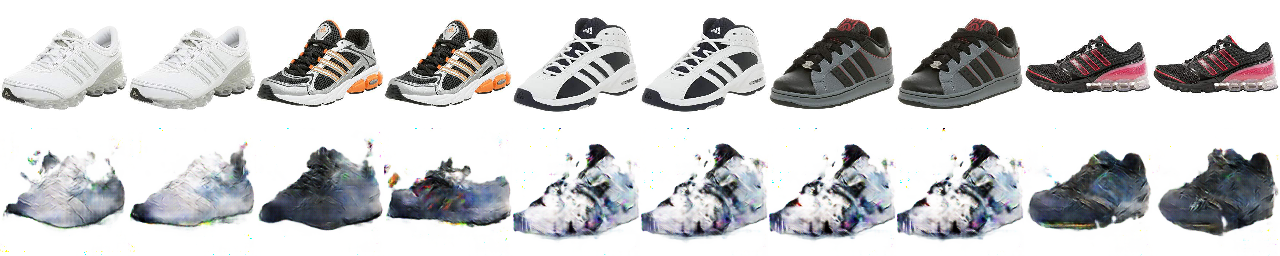

In [103]:
concat_image(real_images + images,2,len(images)) # 1950

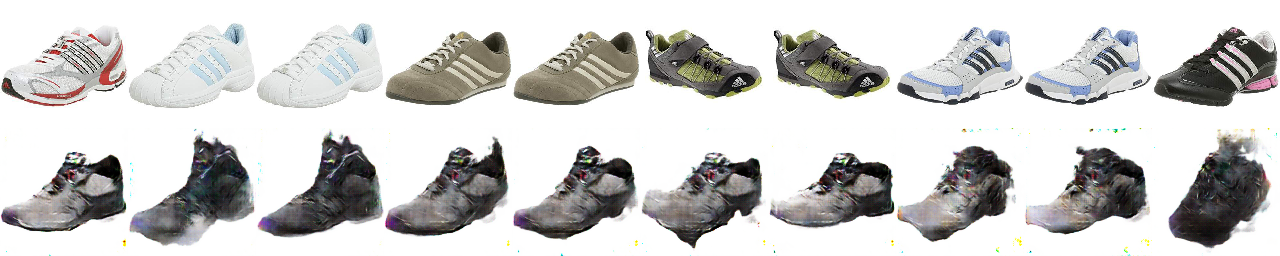

In [26]:
concat_image(real_images + images,2,len(images)) # 1950

### val sample

### test sample

In [124]:
check_text = [
    'adidasbasketball shoes','nike basketball shoes']


In [133]:
imgs = []
for i, t in enumerate(check_text):
    text = t #'schecter c 1 classic electric guitar blue solid body'
    caption = Variable(torch.from_numpy(parser.text2vec(text).reshape(1,-1)))
    noise = Variable(torch.randn(1, 100)) # create random noise
    noise.data.normal_(0,1) # normalize the noise
    fake = netG(noise, caption)
    img = transform(fake[0].data)
    imgs.append(img)

In [134]:
blank = Image.new('RGB',(128, 128), (255, 255, 255, 255))

In [135]:
blackline = [blank]*4

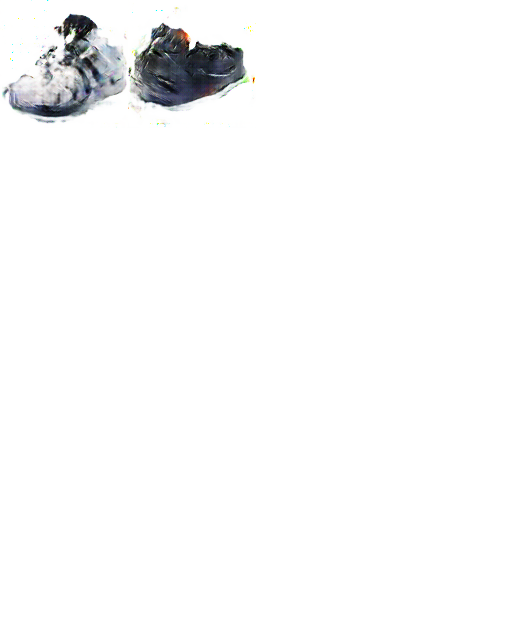

In [136]:
concat_image(imgs[:4] + blackline + imgs[4:8] + blackline + imgs[8:12],5,4)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15895 entries, 0 to 15894
Data columns (total 4 columns):
0    15895 non-null object
1    15895 non-null object
2    15895 non-null object
3    15895 non-null object
dtypes: object(4)
memory usage: 496.8+ KB


In [27]:
s = df[1].value_counts()
s#s[(s>12000) & (s < 13500)]

Clothing,Shoes&Jewelry>Women>Shoes>Boots    16270
Clothing,Shoes&Jewelry>N>Nike               14331
Clothing,Shoes&Jewelry>adidas               10274
Name: 1, dtype: int64

In [253]:
sub = df[df[1] == 'Tools&HomeImprovement>Lighting&CeilingFans>Lamps&Shades>TableLamps']
imgdir = 'data/datasets/products/images/'
images = []
sub.info()
for i, row in sub.iterrows():
    asin = row[0]
    title = row[2]
    print(i, asin, title)
    try:
        images.append(Image.open( imgdir+ asin +'.jpg').resize((128,128)))
    except:
        pass
    if len(images) == 100:
        break

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12554 entries, 0 to 183875
Data columns (total 4 columns):
0    12554 non-null object
1    12554 non-null object
2    12554 non-null object
3    12554 non-null object
dtypes: object(4)
memory usage: 490.4+ KB
0 001212835X lamps shades table lamps tools home improvement lighting ceiling fans everett's cottage table lamp
1 001212835X everett's cottage table lamp lamps shades table lamps tools home improvement lighting ceiling fans
4 9177123026 ikea ljus aring s uv aring s table lamp blue tools home improvement lamps shades lighting ceiling fans table lamps
5 9177123026 tools home improvement lamps shades lighting ceiling fans table lamps ikea ljus aring s uv aring s table lamp blue
6 9177124200 ikea lamps shades table lamps tools home improvement lighting ceiling fans ikea 500 291 62 alang nickel plated table lamp white
7 9177124200 ikea ikea 500 291 62 alang nickel plated table lamp white lamps shades table lamps tools home improvement l

In [254]:
index = 0
showimages = images[index:index+10]

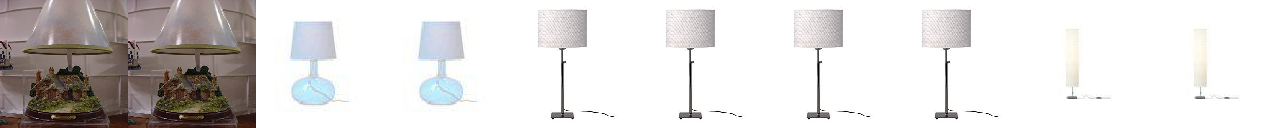

In [255]:
concat_image(showimages,1,len(showimages))

# cate select

In [ ]:
# ,Clothing,Shoes&Jewelry>adidas
# ,Home&Kitchen>Furniture>LivingRoomFurniture>Tables
# ,Clothing,Shoes&Jewelry>Women>Clothing>Coats&Jackets
# ,Beauty>Makeup>Lips>Lipstick
# ,Clothing,Shoes&Jewelry>Women>Shoes>Boots
# ,Clothing,Shoes&Jewelry>Girls>Clothing>Dresses
# ,Clothing,Shoes&Jewelry>Women>Accessories>Hats&Caps
# ,Clothing,Shoes&Jewelry>Women>Clothing>Skirts
# ,Clothing,Shoes&Jewelry>Women>Handbags&Wallets>ShoulderBags
# ,Automotive>Motorcycle&Powersports>ProtectiveGear>Helmets
# ,Clothing,Shoes&Jewelry>N>Nike
# ,Tools&HomeImprovement>Lighting&CeilingFans>Lamps&Shades>TableLamps